In [1]:
from ib_insync import *
import src.floor_ceiling_regime as fcr
import scripts.trend_viewer
util.startLoop()
port = 4001
ib = IB()
ib.connect('127.0.0.1', port, clientId=0)

<IB connected to 127.0.0.1:4001 clientId=0>

In [2]:
%matplotlib inline

In [3]:
c = ib.reqContractDetails(Contract(symbol='MES', secType='FUT', includeExpired=False))
c_df = util.df(c)
c_df

,contract,marketName,minTick,orderTypes,validExchanges,priceMagnifier,underConId,longName,contractMonth,industry,...,callable,putable,coupon,convertible,maturity,issueDate,nextOptionDate,nextOptionType,nextOptionPartial,notes
0,"Contract(secType='FUT', conId=620731036, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202406,,...,False,False,0,False,,,,,False,
1,"Contract(secType='FUT', conId=637533398, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202409,,...,False,False,0,False,,,,,False,
2,"Contract(secType='FUT', conId=654503314, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202412,,...,False,False,0,False,,,,,False,
3,"Contract(secType='FUT', conId=672387462, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202503,,...,False,False,0,False,,,,,False,
4,"Contract(secType='FUT', conId=691171673, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202506,,...,False,False,0,False,,,,,False,


In [4]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import notes.strategy.logic.strategies as strategy
import notes.strategy.logic.indicators as indicator


def run(symbol, sec_type, interval='1 min', duration='1 D', use_rth=True, find_retest_swing=True, keep_up_to_date=True):
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    _bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=keep_up_to_date
    )
    strat = strategy.Custom(
        indicators=[
            indicator.TradingRange(high_band_pct=.40, low_band_pct=.61, window=256),
            indicator.Regime(),
        ]
    )
    # def fc_data_from_bars(bars):
    #     prices = util.df(bars).reset_index().rename(columns={'index': 'bar_number'})
    #     tables = fcr.fc_scale_strategy_live(prices, find_retest_swing=find_retest_swing, regime_threshold=0.5)
    #     tables.enhanced_price_data = tables.enhanced_price_data[['close']].reset_index().rename(columns={'index': 'bar_number'})
    #     return tables
    
    def plot_fc_tables(title):
        tables = strat.indicators[1].value
        plot_prices = tables.enhanced_price_data.copy()
        
        plot_prices = scripts.trend_viewer.setup_trend_view_graph_simple(
            plot_prices, 
            tables.regime_table, 
            tables.peak_table, 
            tables.floor_ceiling_table
        )
        plot_prices['trading_range_lo_band'] = strat.indicators[0].upper.reset_index(drop=True)
        plot_prices['trading_range_hi_band'] = strat.indicators[0].lower.reset_index(drop=True)
        scripts.trend_viewer.plot(plot_prices[-600:], title)
        plt.show()
        clear_output(wait=True)
    
    def onBarUpdate(bars, hasNewBar):
        title = f'{bars.contract.symbol} {bars[-2].date}'
        if hasNewBar:
            # exclude the last bar because it is not complete
            prices = util.df(bars)
            prices.index = prices.date 
            prices = prices.drop(columns=['date'])
            strat.update(prices.close.copy())
            plot_fc_tables(title)
    
    if keep_up_to_date:
        _bars.updateEvent += onBarUpdate
        ib.sleep(100000)
        ib.cancelHistoricalData(_bars)
    else:
        onBarUpdate(_bars, True)
    
# calculate RSI run through floor ceiling?

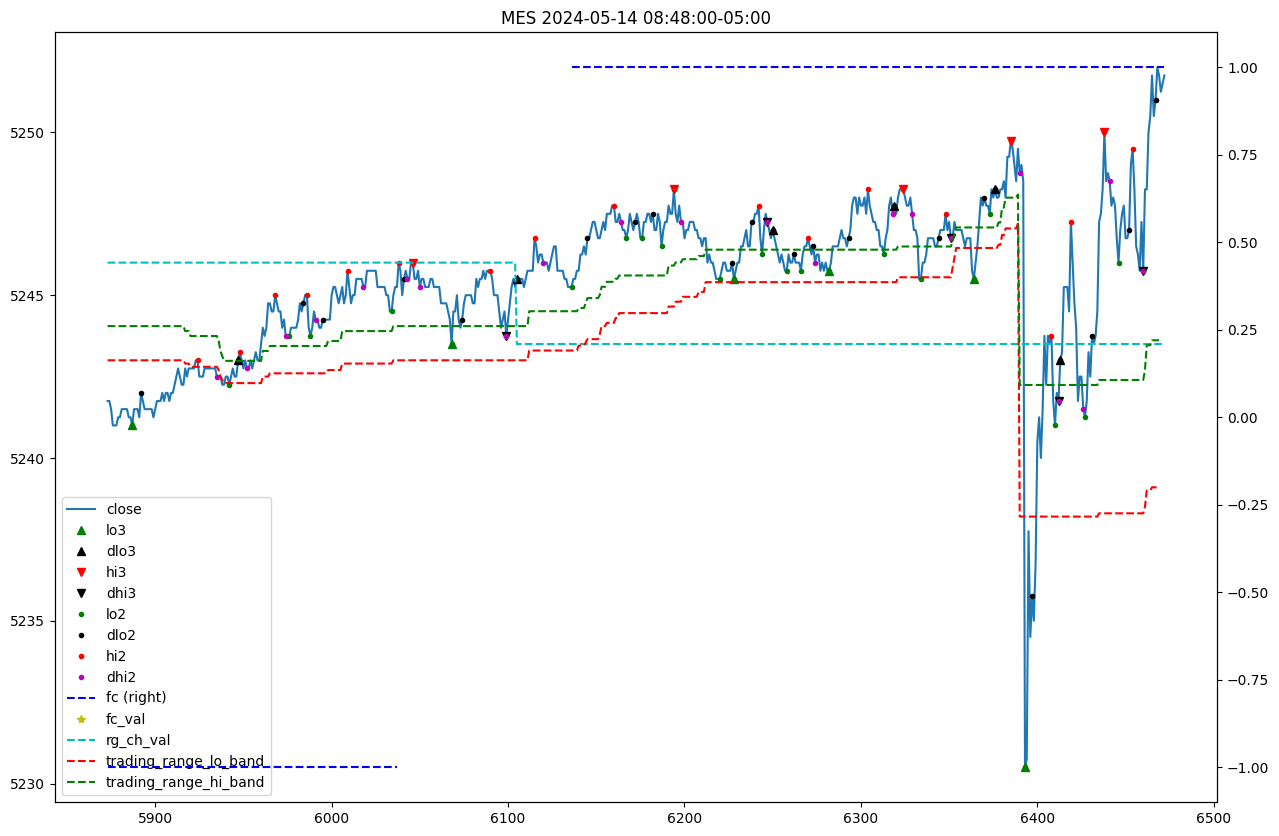

In [5]:
run(
    symbol='MES', 
    sec_type='FUT',
    interval='1 min', 
    duration='5 D',
    use_rth=False,
    find_retest_swing=False,
    keep_up_to_date=True
    )
